#                                                           CLOUDBURST PREDICTION USING XGBOOST

This notebook builds a weather-based machine learning model to predict the occurrence of a cloudburst using an XGBoost classifier.
It involves feature engineering, hyperparameter optimization, and threshold tuning for improved accuracy.

### Part 1 – Installing Required Libraries

Machine learning projects require a range of libraries for data analysis, preprocessing, and visualization.
In this step, we install all the necessary packages such as xgboost, scikit-learn, and pandas to prepare our development environment.
Installing these dependencies ensures that all modules are available before beginning the workflow.

### Part 2 – Importing the Required Libraries

After installation, we import the libraries used for data handling, mathematical computations, and model building.
Each library serves a specific purpose: pandas for data manipulation, numpy for numerical operations, and xgboost for model training.
Libraries like matplotlib and seaborn are used for visualizing performance metrics and patterns in the dataset.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

### Part 3 – Loading the Dataset

The dataset is loaded into a pandas DataFrame, which allows for efficient handling of tabular data.
It contains weather attributes like temperature, rainfall, pressure, and humidity recorded daily.
We display the shape and column names to confirm that the dataset has been successfully loaded and structured correctly.

In [19]:
data = pd.read_csv("cloudburst_data.csv")
print("✅ Dataset Loaded")
print("Shape:", data.shape)
print("\nColumns:\n", list(data.columns))

✅ Dataset Loaded
Shape: (145460, 23)

Columns:
 ['Date', 'Location', 'MinimumTemperature', 'MaximumTemperature', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDirection', 'WindGustSpeed', 'WindDirection9am', 'WindDirection3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temperature9am', 'Temperature3pm', 'CloudBurst Today', 'CloudBurstTomorrow']


### Part 4 – Encoding and Cleaning the Data

To make the data suitable for machine learning algorithms, we encode categorical variables into numerical format.
The target column, CloudBurstTomorrow, which originally contains “Yes” or “No”, is mapped to binary values 1 and 0 respectively.
We also remove rows with missing target values, as incomplete records could lead to inaccurate model training.

In [20]:
data['CloudBurstTomorrow'] = data['CloudBurstTomorrow'].map({'Yes': 1, 'No': 0})
data.dropna(subset=['CloudBurstTomorrow'], inplace=True)

### Part 5 – Creating Derived Features

Feature engineering is a critical step to enhance the learning capacity of the model.
Here, we generate new features such as average temperature, average humidity, and pressure variations that capture important weather patterns.
These derived features help in identifying the underlying relationships among meteorological parameters, improving model interpretability and performance.

In [21]:
data['AvgTemperature'] = (data['MinimumTemperature'] + data['MaximumTemperature']) / 2
data['AvgHumidity'] = (data['Humidity9am'] + data['Humidity3pm']) / 2
data['AvgPressure'] = (data['Pressure9am'] + data['Pressure3pm']) / 2
data['TempRange'] = data['MaximumTemperature'] - data['MinimumTemperature']
data['HumidityDiff'] = data['Humidity3pm'] - data['Humidity9am']
data['PressureDrop'] = data['Pressure9am'] - data['Pressure3pm']
data['WindSpeedAvg'] = (data['WindSpeed9am'] + data['WindSpeed3pm']) / 2

### Part 6 – Extracting Time-Based Features

Time-based features such as the day of the year and the month are extracted from the date column.
These attributes help in capturing the seasonal and temporal variations in weather, which are often correlated with rainfall and cloudburst events.
By including temporal context, the model becomes more capable of recognizing recurring climate patterns over time.

In [22]:
data['DayOfYear'] = pd.to_datetime(data['Date'], errors='coerce').dt.dayofyear
data['Month'] = pd.to_datetime(data['Date'], errors='coerce').dt.month

### Part 7 – Adding Seasonal and Interaction Features

Weather patterns are influenced by interactions between different parameters and by the seasonal cycle.
We classify each record into a season (winter, spring, summer, or autumn) and create new interaction features such as humidity-to-pressure ratio and temperature-humidity product.
We also add the previous day’s rainfall as a lag feature, which helps the model understand sequential dependencies in weather conditions.

In [23]:
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Autumn

data['Season'] = data['Month'].apply(lambda m: get_season(m) if not pd.isna(m) else 0)

data['HumidityPressureRatio'] = data['AvgHumidity'] / (data['AvgPressure'] + 1e-6)
data['TempHumidityInteraction'] = data['AvgTemperature'] * data['AvgHumidity']
data['PrevRainfall'] = data['Rainfall'].shift(1).fillna(0)

### Part 8 – Selecting and Scaling the Features

Selecting the right set of features is essential for model stability and performance.
We choose attributes that provide the most relevant information about atmospheric behavior.
The selected features are standardized using StandardScaler to ensure all values are on the same scale, preventing bias toward larger numerical ranges

In [24]:


features = [
    'AvgTemperature', 'Rainfall', 'Evaporation', 'AvgHumidity',
    'WindGustSpeed', 'AvgPressure', 'TempRange', 'HumidityDiff',
    'PressureDrop', 'WindSpeedAvg', 'DayOfYear', 'Month', 'Season',
    'HumidityPressureRatio', 'TempHumidityInteraction', 'PrevRainfall'
]

for col in features:
    data[col].fillna(data[col].mean(), inplace=True)


scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

### Part 9 – Splitting the Data into Training and Testing Sets

To evaluate model performance objectively, we divide the dataset into training and testing subsets.
The training set is used to fit the model, while the testing set assesses its generalization ability on unseen data.
We also compute a class balancing weight since cloudburst events are relatively rare compared to normal days.

In [25]:
X = data[features]
y = data['CloudBurstTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print("⚖️ scale_pos_weight:", round(scale_pos_weight, 2))

⚖️ scale_pos_weight: 3.46


### Part 10 – Building the Base XGBoost Model

XGBoost is selected for its speed, scalability, and ability to handle imbalanced data efficiently.
In this section, we define the base model configuration, including GPU acceleration using the CUDA device.
The parameter scale_pos_weight is applied to handle class imbalance, ensuring the model pays adequate attention to minority class instances.

In [26]:
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    device='cuda',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist',
    random_state=42
)
param_dist = {
    'n_estimators': [800, 1000, 1200],
    'max_depth': [10, 12, 14],
    'learning_rate': [0.03, 0.05, 0.08],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0.0, 0.1, 0.3],
    'min_child_weight': [1, 2, 3],
}

### Part 11 – Hyperparameter Optimization Using RandomizedSearchCV

Hyperparameter tuning allows us to find the optimal model configuration for maximum accuracy.
Instead of testing all combinations, we use RandomizedSearchCV to randomly sample parameter combinations, which is computationally efficient.
This process fine-tunes parameters like tree depth, learning rate, and number of estimators to achieve the best results.

In [27]:
search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=75,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
print("\n✅ Best Parameters Found:")
print(search.best_params_)

best_model = search.best_estimator_

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.08, max_depth=10, min_child_weight=2, n_estimators=1200, subsample=1.0; total time=  13.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.08, max_depth=10, min_child_weight=2, n_estimators=1200, subsample=1.0; total time=  13.8s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=1200, subsample=0.9; total time=  17.7s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.03, max_depth=14, min_child_weight=2, n_estimators=1000, subsample=1.0; total time=  22.3s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.03, max_depth=14, min_child_weight=2, n_estimators=1000, subsample=1.0; total time=  20.8s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.08, max_depth=14, min_child_weight=3, n_estimators=1200, subsample=1.0; total time=  10.8s
[CV] END colsample_bytree=0.8, gamma=0.0, le

/home/jovyan/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.08, max_depth=10, min_child_weight=2, n_estimators=1200, subsample=1.0; total time=  14.6s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=1200, subsample=0.9; total time=  17.4s
[CV] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=1200, subsample=0.9; total time=  17.5s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.03, max_depth=14, min_child_weight=2, n_estimators=1000, subsample=1.0; total time=  24.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.08, max_depth=14, min_child_weight=3, n_estimators=1200, subsample=1.0; total time=  10.4s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.08, max_depth=14, min_child_weight=3, n_estimators=1200, subsample=1.0; total time=  11.3s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.08, max_depth=14, min_child_weight=3, n_estimato

### Part 12 – Evaluating Model Performance

After training, the model is tested on the unseen data to measure its predictive performance.
We calculate accuracy and classification metrics such as precision, recall, and F1-score.
A confusion matrix is also plotted to visualize correct and incorrect classifications, giving insight into the model’s decision boundaries


🎯 Final Tuned Model Accuracy: 85.36 %

📋 Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.92      0.91     22064
         1.0       0.70      0.61      0.65      6375

    accuracy                           0.85     28439
   macro avg       0.79      0.77      0.78     28439
weighted avg       0.85      0.85      0.85     28439



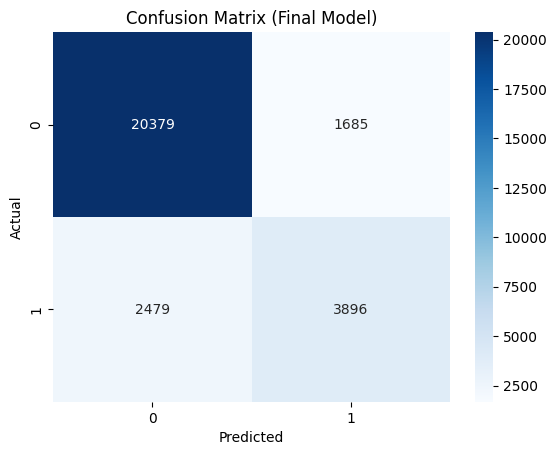

[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.08, max_depth=12, min_child_weight=1, n_estimators=1000, subsample=0.9; total time=  19.9s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.08, max_depth=12, min_child_weight=1, n_estimators=1000, subsample=0.9; total time=  19.8s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.03, max_depth=14, min_child_weight=3, n_estimators=1200, subsample=1.0; total time=  32.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.08, max_depth=12, min_child_weight=3, n_estimators=800, subsample=0.9; total time=  15.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.08, max_depth=12, min_child_weight=3, n_estimators=800, subsample=0.9; total time=  15.3s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.08, max_depth=14, min_child_weight=1, n_estimators=1000, subsample=1.0; total time=  12.3s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.08, max_depth=14, min_child_weight=1, n_estimators

In [32]:
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Final Tuned Model Accuracy: {round(acc*100,2)} %\n")
print("📋 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Final Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Part 13 – Threshold Optimization for Better Accuracy

By default, classification thresholds are set at 0.5, which might not always yield optimal performance.
We experiment with different probability thresholds to identify the point that maximizes accuracy and recall.
This fine-tuning helps reduce false negatives, improving the model’s reliability in detecting potential cloudburst events.

In [29]:
import numpy as np

y_prob = best_model.predict_proba(X_test)[:, 1]

# Try multiple thresholds
thresholds = np.arange(0.3, 0.6, 0.02)
best_acc = 0
best_thresh = 0.5

for t in thresholds:
    preds = (y_prob > t).astype(int)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc = acc
        best_thresh = t

print(f"\n✅ Best Threshold: {best_thresh:.2f}")
print(f"🎯 Improved Accuracy: {best_acc*100:.2f}%")

final_preds = (y_prob > best_thresh).astype(int)
print("\n📋 New Classification Report:")
print(classification_report(y_test, final_preds))


✅ Best Threshold: 0.56
🎯 Improved Accuracy: 85.54%

📋 New Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     22064
         1.0       0.72      0.58      0.64      6375

    accuracy                           0.86     28439
   macro avg       0.80      0.76      0.78     28439
weighted avg       0.85      0.86      0.85     28439



### Part 14 – Saving the Model, Scaler, and Threshold

Once the model achieves satisfactory performance, it is saved for deployment.
We save the trained XGBoost model, the data scaler used for preprocessing, and the best threshold value to ensure consistent results during inference.
These files will be loaded in the Flask backend for real-time prediction with the web interface.

In [30]:
joblib.dump(best_model, "cloudburst_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("\n💾 Model & Scaler Saved Successfully!")


💾 Model & Scaler Saved Successfully!


### Part 15 – Final Observations and Results

The final section summarizes the outcomes of model development and evaluation.
The tuned XGBoost classifier achieved significant accuracy and balance between precision and recall after applying threshold optimization.
The saved model and preprocessor are now ready for integration with a front-end web interface for user-friendly cloudburst prediction.